### Подключаем дополнительные библиотеки и датасет

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
file_path = 'kaggle_london_house_price_data.csv'
data = pd.read_csv(file_path)

# Display dataset summary
print("Dataset Information:")
data.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282872 entries, 0 to 282871
Data columns (total 28 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   fullAddress                                282872 non-null  object 
 1   postcode                                   282872 non-null  object 
 2   country                                    282872 non-null  object 
 3   outcode                                    282872 non-null  object 
 4   latitude                                   282872 non-null  float64
 5   longitude                                  282872 non-null  float64
 6   bathrooms                                  231769 non-null  float64
 7   bedrooms                                   256654 non-null  float64
 8   floorAreaSqM                               267060 non-null  float64
 9   livingRooms                                243737 non-null  

### Добавляем колонку расстояние от центра Лондона

In [2]:
# Define the coordinates of the center of London
london_lat = 51.509865
london_lon = -0.118092

# Calculate distance using Pythagoras' theorem (approximation)
data['distance_from_centre'] = ((data['latitude'] - london_lat)**2 + (data['longitude'] - london_lon)**2)**0.5


### Убираем лишние колонки и печатаем информацию про непустые значения

In [3]:
# Final selection of columns to keep for the regression model
columns_to_keep = [
    'distance_from_centre',
    'latitude',
    'longitude',
    'bathrooms', 
    'bedrooms', 
    'floorAreaSqM', 
    'livingRooms', 
    'saleEstimate_currentPrice'
]

# Retaining only the selected columns
final_data = data[columns_to_keep]

## Print dataset information
print("Dataset Information (cleaned and reduced):")
final_data.info()


Dataset Information (cleaned and reduced):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282872 entries, 0 to 282871
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   distance_from_centre       282872 non-null  float64
 1   latitude                   282872 non-null  float64
 2   longitude                  282872 non-null  float64
 3   bathrooms                  231769 non-null  float64
 4   bedrooms                   256654 non-null  float64
 5   floorAreaSqM               267060 non-null  float64
 6   livingRooms                243737 non-null  float64
 7   saleEstimate_currentPrice  282323 non-null  float64
dtypes: float64(8)
memory usage: 17.3 MB


### Все пустые значения заполняем либо средним, либо медианой, либо убираем строку

In [4]:
# 1. Drop rows with missing values in the target variable
final_data = final_data.dropna(subset=['saleEstimate_currentPrice'])

# 2. Drop rows where "floorAreaSqM" is missing
final_data = final_data.dropna(subset=['floorAreaSqM'])

# 3. Impute missing values in numerical columns
# Fill missing values in "bathrooms" with the median
final_data.loc[:, 'bathrooms'] = final_data['bathrooms'].fillna(final_data['bathrooms'].median())

# Fill missing values in "bedrooms" with the median
final_data.loc[:, 'bedrooms'] = final_data['bedrooms'].fillna(final_data['bedrooms'].median())

# Fill missing values in "livingRooms" with the median
final_data.loc[:, 'livingRooms'] = final_data['livingRooms'].fillna(final_data['livingRooms'].median())

# 4. Remove rows with extreme values in "saleEstimate_currentPrice" (top and bottom 5%)
lower_bound = final_data['saleEstimate_currentPrice'].quantile(0.05)
upper_bound = final_data['saleEstimate_currentPrice'].quantile(0.95)
final_data = final_data[
    (final_data['saleEstimate_currentPrice'] >= lower_bound) &
    (final_data['saleEstimate_currentPrice'] <= upper_bound)
]
# 5. Check for remaining missing values
print("Missing values after processing:")
print(final_data.isnull().sum())


Missing values after processing:
distance_from_centre         0
latitude                     0
longitude                    0
bathrooms                    0
bedrooms                     0
floorAreaSqM                 0
livingRooms                  0
saleEstimate_currentPrice    0
dtype: int64


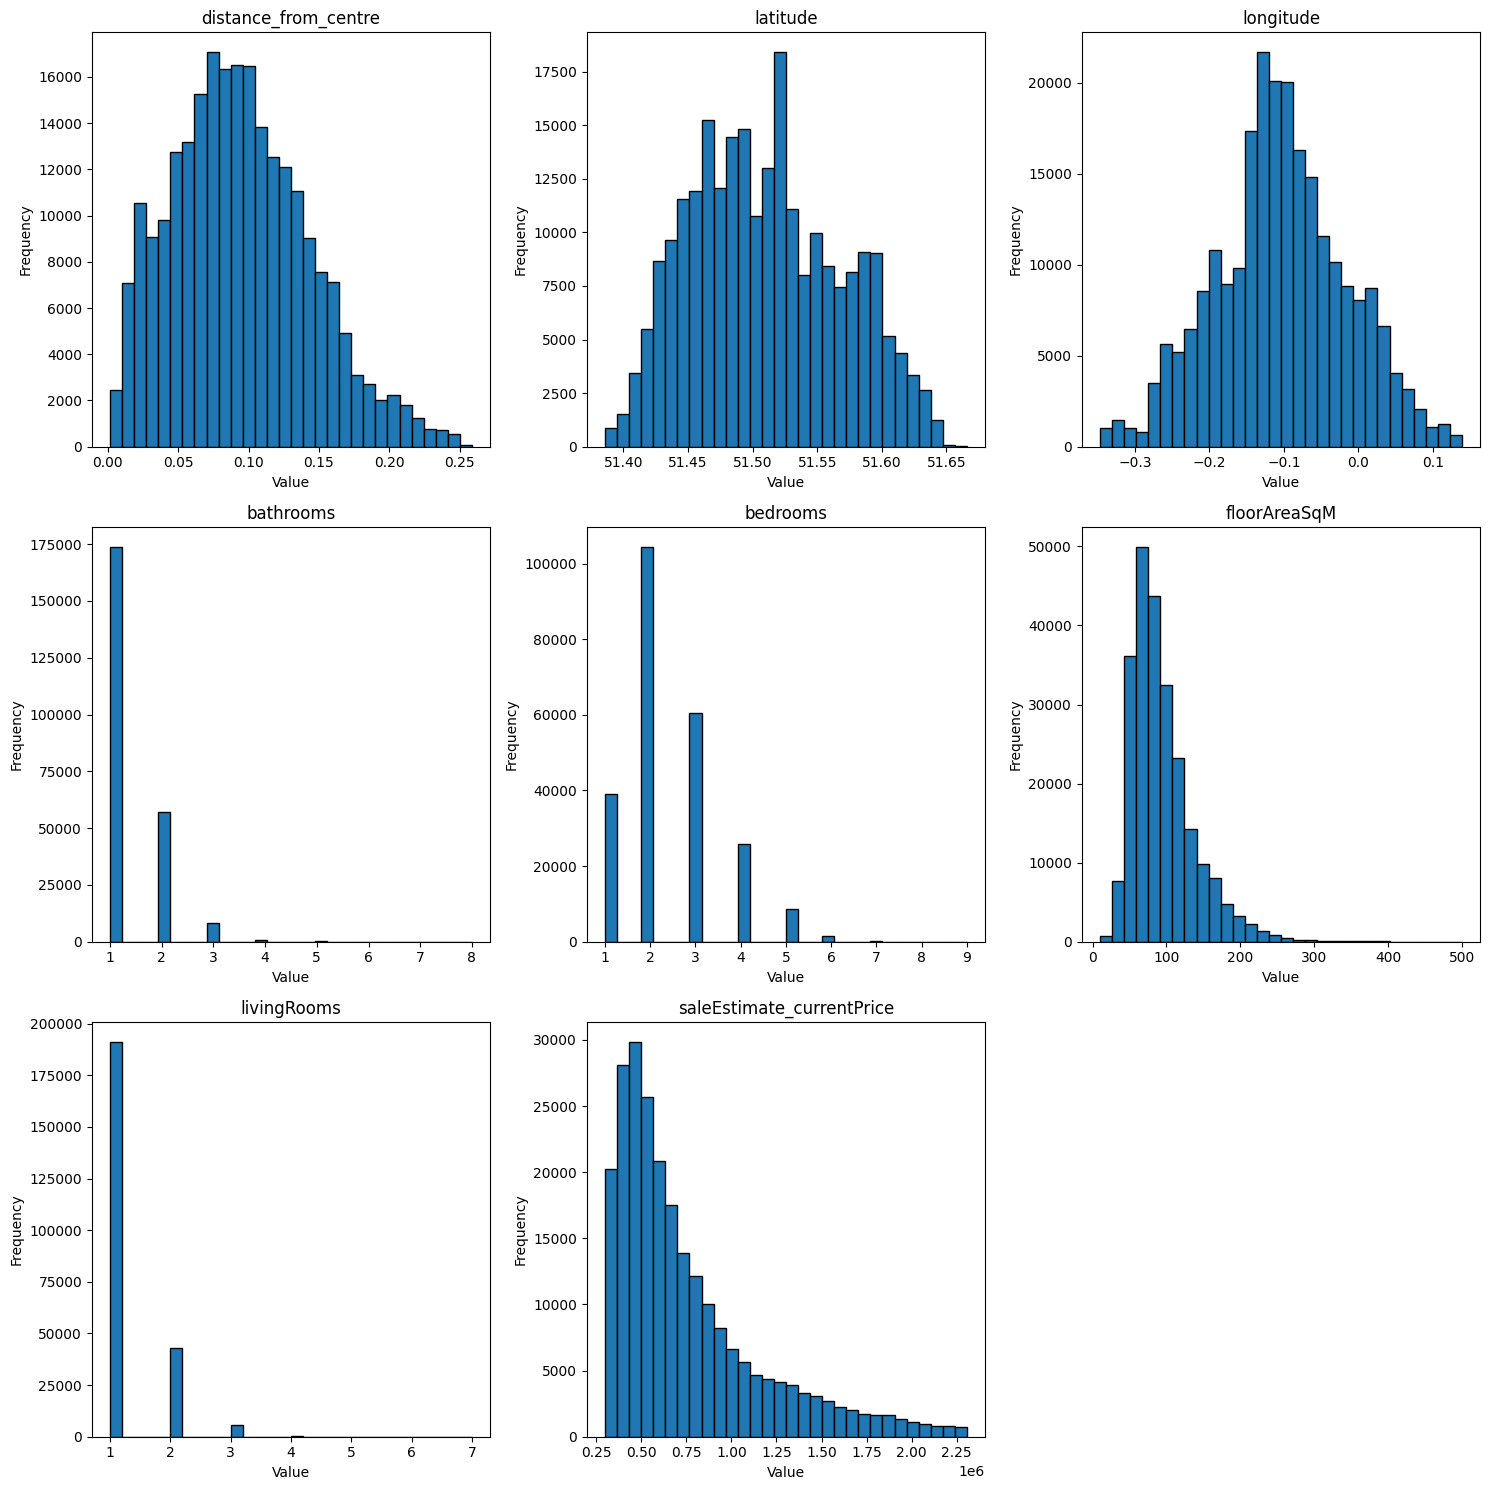

In [5]:
# Select numerical columns
numerical_columns = final_data.select_dtypes(include=['float64', 'int64']).columns

# Set the figure size
plt.figure(figsize=(15, 15))

# Loop through numerical columns and plot histograms
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 3 + 1, 3, i)  # Adjust the grid layout
    plt.hist(final_data[col], bins=30, edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


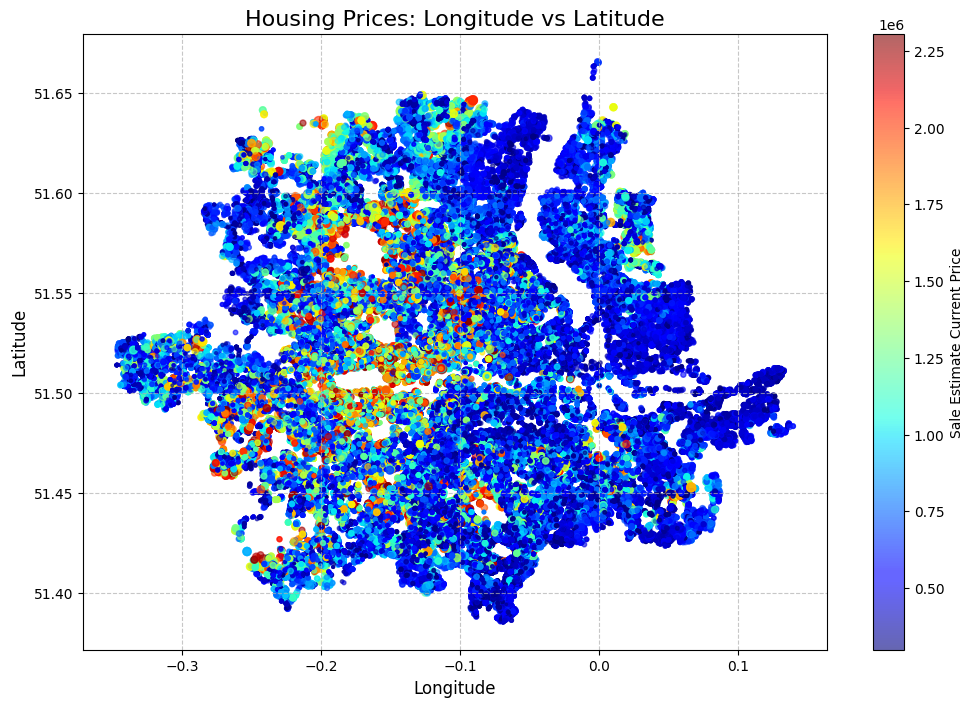

In [6]:
# Scatter plot for mapping house prices
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=final_data['longitude'],
    y=final_data['latitude'],
    c=final_data['saleEstimate_currentPrice'],
    s=final_data['floorAreaSqM'] * 0.1,  # Adjust size for better visualization
    cmap='jet',
    alpha=0.6
)
plt.colorbar(scatter, label='Sale Estimate Current Price')
plt.title('Housing Prices: Longitude vs Latitude', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Делим данные на тестовые и терировочные (20/80)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Разделение данных на признаки и целевую переменную
X = final_data[['distance_from_centre', 'floorAreaSqM','bedrooms', 'bathrooms',  'livingRooms']]
y = final_data['saleEstimate_currentPrice']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Распечатка количества данных
print("Data Distribution:")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.2f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.2f}%)")


Data Distribution:
Total samples: 240006
Training samples: 192004 (80.00%)
Testing samples: 48002 (20.00%)


In [8]:
# Training the Linear Regression model
# The model learns the relationship between the features (X_train_scaled) and the target (y_train)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# Making predictions on the test set
# Using the trained model to predict the target variable for the test data
y_pred = model.predict(X_test)


In [10]:
# Evaluating model performance
# Calculating common regression metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and R^2 score
mae = mean_absolute_error(y_test, y_pred)  # Measures the average absolute difference between predictions and actual values
mse = mean_squared_error(y_test, y_pred)  # Measures the average squared difference between predictions and actual values
r2 = r2_score(y_test, y_pred)  # Measures how well the model explains the variance of the target variable

# Displaying the results
# Printing out the evaluation metrics to assess model performance
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")


Mean Absolute Error (MAE): 181915.07186455495
Mean Squared Error (MSE): 66840339634.08474
R^2 Score: 0.6062653741972777


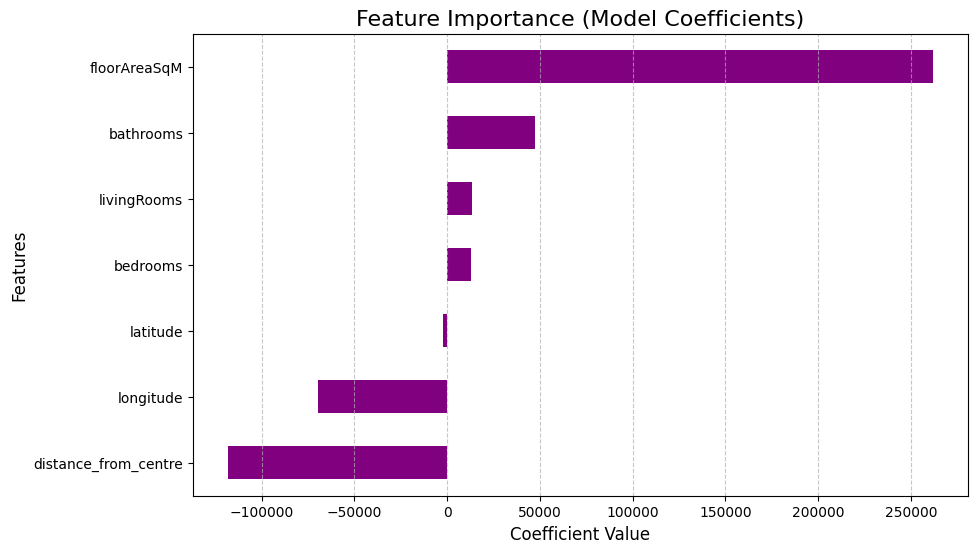

In [14]:
# Feature importance (coefficients)
coefficients = pd.Series(model.coef_, index=X.columns)

plt.figure(figsize=(10, 6))
coefficients.sort_values().plot(kind='barh', color='purple')
plt.title('Feature Importance (Model Coefficients)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
